# Assignment 5: The Traveling Salesman Problem
In our last assignment, we added crossover to the mix, completing the last major piece of our evolutionary algorithm framework!  Let's use this basic pipeline to explore a real-world applied problem to help gain an understanding of the complexity of using representations beyond basic bit-strings.  

In this assignment, we'll explore the Traveling Salesman Problem (TSP).  This problem specifies that a solution should visit each of a list of locations exactly one time, and do so by traveling the shortest distance possible. 

In [1]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance

from IPython.display import clear_output
import time

Most of my family's road trips are based around getting outside a seeing national parks, so let's optimize a TSP to visit the list of US National Parks.  This list of all parks, and their coordinates, is included in the zip folder for this assignment.  The below block of code will load this data, ignoring the parks outside the continental US (so we can pretend to drive, instead of flying to Alaska or Hawaii).  Ignoring these, we're left with a list of 50 parks (what counts as a "National Park" is a bit fuzzy, but this is the list I scraped from Wikipedia).  For the most part we'll actually be ignoring the `park_names` and working with `park_lat_long`, which is an 2-D array that provides the coordiantes of each park (indexed in alphabetical order to match the names list -- not that this matters much for our purposes in this assignment).  

In [2]:
file = open("parks_list.csv", encoding='utf-8')
park_names = []
park_lat_long = []
for line in file:
    park_name = line.split(",")[0].strip()
    park_lat = float(line.split(",")[1].strip())
    park_long = float(line.split(",")[2].strip())
    
    if park_lat > -125 and park_lat < -65 and park_long > 25 and park_lat < 50: # just look at continental US
        park_names.append(park_name)
        park_lat_long.append([park_lat,park_long])
        
file.close()
park_lat_long = np.array(park_lat_long) # convert to numpy array for easier indexing/slicing

print("Number of National Parks in Continental US:",len(park_names))
print(park_names)

print(park_lat_long)

Number of National Parks in Continental US: 50
['Acadia', 'Arches', 'Badlands', 'Big Bend', 'Biscayne', 'Black Canyon of the Gunnison', 'Bryce Canyon', 'Canyonlands', 'Capitol Reef', 'Carlsbad Caverns', 'Channel Islands', 'Congaree', 'Crater Lake', 'Cuyahoga Valley', 'Death Valley', 'Everglades', 'Gateway Arch', 'Glacier', 'Grand Canyon', 'Grand Teton', 'Great Basin', 'Great Sand Dunes', 'Great Smoky Mountains', 'Guadalupe Mountains', 'Hot Springs', 'Indiana Dunes', 'Isle Royale', 'Joshua Tree', 'Kings Canyon', 'Lassen Volcanic', 'Mammoth Cave', 'Mesa Verde', 'Mount Rainier', 'New River Gorge', 'North Cascades', 'Olympic', 'Petrified Forest', 'Pinnacles', 'Redwood', 'Rocky Mountain', 'Saguaro', 'Sequoia', 'Shenandoah', 'Theodore Roosevelt', 'Voyageurs', 'White Sands', 'Wind Cave', 'Yellowstone', 'Yosemite', 'Zion']
[[ -68.21     44.35  ]
 [-109.57     38.68  ]
 [-102.5      43.75  ]
 [-103.25     29.25  ]
 [ -80.08     25.65  ]
 [-107.72     38.57  ]
 [-112.18     37.57  ]
 [-109.93   

Given that we know the coordinates of each park, a fun dataviz we can do is to superimpose the parks on a map of the United States.

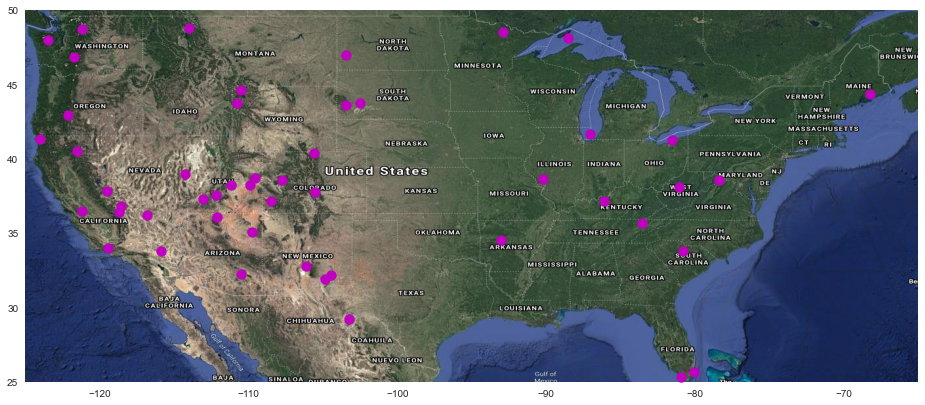

In [3]:
fig, ax = plt.subplots(figsize=(16, 8)) # generate figure and axes
ax.imshow(plt.imread("us_map.png"), extent=[-125, -65, 25, 50]) # import backbround
ax.scatter(park_lat_long[:,0],park_lat_long[:,1],color='m',s=100) # plot each park at its coordinates
ax.set_xlim([-125,-65]);
ax.set_ylim([25,50]);
ax.grid(False);

Since we'll be opitmizing routes between these parks, it would also be good to be able to draw routes between two parks.  For the sake of simplicity (i.e. so you don't need to interface with the Google Maps API), we'll just consider straight-line distance between parks as a proxy for driving distance.  An example of how to draw a line showing a path between parks might look something like this.

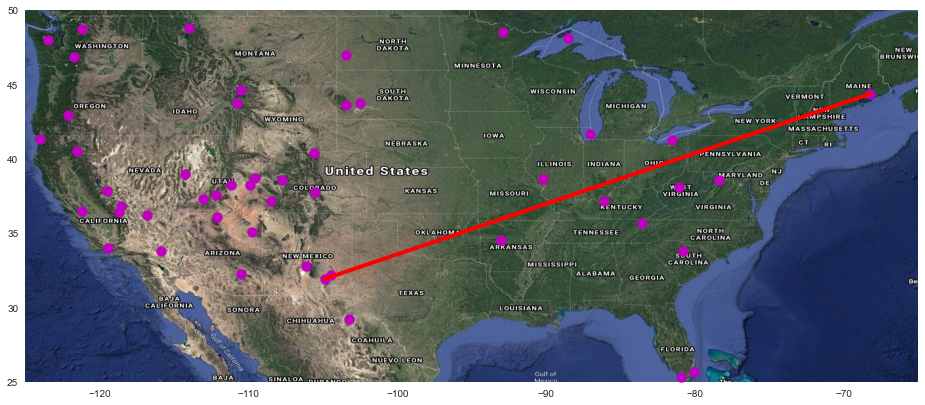

In [4]:
fig, ax = plt.subplots(figsize=(16, 8)) # generate figure and axes
ax.imshow(plt.imread("us_map.png"), extent=[-125, -65, 25, 50]) # import backbround
ax.scatter(park_lat_long[:,0],park_lat_long[:,1],color='m',s=100) # plot each park at its coordinates
ax.set_xlim([-125,-65]);
ax.set_ylim([25,50]);
ax.grid(False);

park1_index = 0 # pick to arbitrary parks for this demo example
park2_index = 23
ax.plot([park_lat_long[park1_index,0],park_lat_long[park2_index,0]],[park_lat_long[park1_index,1],park_lat_long[park2_index,1]],color='r',linewidth=4); # draw a line between them

### Q1: TSP Ftiness Function
Define a fitness function that takes a genome of park indexes and calculates the total round trip distance from the starting point (first park) back around a full cycle to end up at the park you started in.  

Recall that we are using the straight-line distance between parks (and you may find it useful to make a helper function which calculated the distance between any two indidivual parks in calculating the total distance traveled).

To minimize the modifications necessary to your existing evolutionary algorithm code, which maximized fitness, return the negative of the distance traveled (i.e. fitness will always be less than zero, with longer trips more negative), so we can continue to maximize fitness values when finding the shortest part for the TSP.

In [5]:
def distance_between_parks(park1_index,park2_index):
    return ((park_lat_long[park1_index][0]-park_lat_long[park2_index][0])**2+(park_lat_long[park1_index][1]-park_lat_long[park2_index][1])**2)**0.5 # pythagorean theorem for straight-line distance

def traveling_salesman_fitness_function(genome):
    total_distance = 0 
    for park_index in range(len(genome)): # for each park
        total_distance -= distance_between_parks(genome[park_index],genome[(park_index+1)%len(genome)]) # add cost for distnce between this park and the next one (looping back to start for last point)
    return total_distance

### Q2: Adapting the Evolutionary Algorithm for the TSP
Copy over your evolutionary algorithm code (both the `Individual` class and the `evolutionary_algorithm` function) from your last assignemnt (or the posted solutions) to provide a framework to get started with.  Now please adopt this code to sovle the TSP.  Let's begin with the simple case of just mutation and not crossover.  Let's also focus on the simpler case of a hard constraint on visiting each loaction just once.  

We mentioned a number of potential representations in class last week, please pick one that enforces each location be visited only once as part of the encoding.  

Let's also begin with a mutation opperator we discussed in class, randomly selecting two locations and swapping their place in the visitation order.  

Additionally, for visualizations later on, please save the timeseries of solutions over time (in addition to the fitness values over time you were saving last assignment).

In [6]:
class Individual:
    
    def __init__(self, fitness_function, genome_length):
        self.genome = np.random.permutation(np.arange(genome_length))
        self.fitness_function = fitness_function
        self.fitness = 0
        
    def eval_fitness(self):
        self.fitness = self.fitness_function(self.genome)

In [7]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=10, num_elements_to_mutate=1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        genome_length: (int) length of the genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
        solutions_over_time: (numpy array) track record of the top genome value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,genome_length),dtype=int)
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,genome_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
            # crossover
            # N/A

            # mutation
            for this_child in [child1,child2]:
                for _ in range(num_elements_to_mutate):
                    [index_to_swap1, index_to_swap2] = sorted(np.random.randint(0,genome_length,2)) # crossover points for 2-point crossover (sorted to make indexing easier in the next step)
                    orig_gene_1 = this_child.genome[index_to_swap1]
                    orig_gene_2 = this_child.genome[index_to_swap2]
                    this_child.genome[index_to_swap1] = orig_gene_2
                    this_child.genome[index_to_swap2] = orig_gene_1
        
            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        population = sorted(population, key=lambda individual: individual.fitness, reverse = True) # sort the full population by each individual's fitness (from highers to lowest)
        
        # tournament selection
        new_population = []
        new_population.append(population[0])
        while len(new_population) < num_parents:
            tournament = np.random.choice(population, size = tournament_size)
            tournament = sorted(tournament, key=lambda individual: individual.fitness, reverse = True)
            new_population.extend(tournament[:num_tournament_winners])    
        population = new_population
        
        # record keeping
        
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num,:] = solution
        
    return fitness_over_time, solutions_over_time # for simplicity, return just the fitness_over_time record

As usual, let's store our results for later plotting

In [8]:
experiment_results = {}
solutions = {}

### Q2: Collect and Analyze Results
Similar to last week, let's run multiple trials to systematically test our algorithm.  To keep compute times down, let's start with a smaller subset of the problem, using just the first half of the parks in our dataset.  

In [9]:
park_names = park_names[:25]
park_lat_long = park_lat_long[:25]

In this smaller problem, let's run for `100` generations, `50` parents + `50` childeren in a mu+alpha evolutionary strategies, a tournament selection of tournaments of size `10` with `2` winners selected at each tournament.  Let's just run this for `20` independent trials.  

For reference (as there were runtime length questions about the last assignment), in my implementation of this, each run taks a little over a second, so all 20 runs finish in under 30 seconds.  

In [10]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
genome_length = len(park_names)
num_parents = 50
num_children = 50
tournament_size = 10
num_tournament_winners = 2

for run_name in ["swap_entries_mutation"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions[run_name] = np.zeros((num_runs, total_generations, genome_length))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time = evolutionary_algorithm(fitness_function=traveling_salesman_fitness_function, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, num_elements_to_mutate=num_elements_to_mutate, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions[run_name][run_num] = solutions_over_time
        print(run_name, run_num, time.time()-start_time,fitness_over_time[-1])

swap_entries_mutation 0 0.9990272521972656 -177.49458340232016
swap_entries_mutation 1 1.0431370735168457 -187.14089577712642
swap_entries_mutation 2 1.0393190383911133 -161.63482072629546
swap_entries_mutation 3 1.0753490924835205 -180.58860967321883
swap_entries_mutation 4 1.0626451969146729 -163.9252270026422
swap_entries_mutation 5 1.0467097759246826 -168.63207424972978
swap_entries_mutation 6 1.0730984210968018 -206.52197770040897
swap_entries_mutation 7 1.0342159271240234 -165.5301441305593
swap_entries_mutation 8 1.0200443267822266 -210.87919711128328
swap_entries_mutation 9 1.0505681037902832 -212.73368974632388
swap_entries_mutation 10 1.0580947399139404 -158.4954159478606
swap_entries_mutation 11 1.0583767890930176 -175.1939839095367
swap_entries_mutation 12 1.0749125480651855 -168.43283128137114
swap_entries_mutation 13 1.0920555591583252 -173.88805351179644
swap_entries_mutation 14 1.0625598430633545 -221.3630078539088
swap_entries_mutation 15 1.0488572120666504 -164.794267

Again pulling from the previous assignment, please plot the mean and boostrapped confidence interval of your experiements.  Again, you may find it convenient to make this into a function (and if you do, FYI, later use cases may involve plotting just the mean without the CI, since this boostrapping proceedure can be computationally expensive).  

In [11]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me", x_label = "change me", y_label="change me", y_limit = None, plot_bootstrap = True):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """

    fig, ax = plt.subplots() # generate figure and axes

    if isinstance(name, str): name = [name]; input_data = [input_data]

    # for this_input_data, this_name in zip(input_data, name):
    for this_name in name:
        print("plotting",this_name)
        this_input_data = experiment_results[this_name]
        total_generations = this_input_data.shape[1]

        if plot_bootstrap:
            boostrap_ci_generation_found = np.zeros((2,total_generations))
            for this_gen in range(total_generations):
                if this_gen%10==0: print(this_gen)
                boostrap_ci_generation_found[:,this_gen] = bootstrap.ci(this_input_data[:,this_gen], np.mean, alpha=0.05)


        ax.plot(np.arange(total_generations), np.mean(this_input_data,axis=0), label = this_name) # plot the fitness over time
        if plot_bootstrap:
            ax.fill_between(np.arange(total_generations), boostrap_ci_generation_found[0,:], boostrap_ci_generation_found[1,:],alpha=0.3) # plot, and fill, the confidence interval for fitness over time
        ax.set_xlabel(x_label) # add axes labels
        ax.set_ylabel(y_label)
        if y_limit: ax.set_ylim(y_limit[0],y_limit[1])
        plt.legend(loc='best'); # add legend

plotting swap_entries_mutation
0
10
20
30
40
50
60
70
80
90


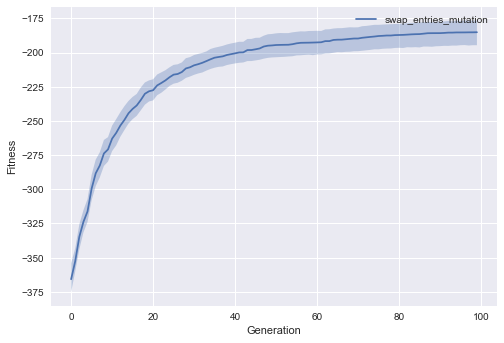

In [12]:
plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results.values(), name = ["swap_entries_mutation"], x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)

One of the most fun parts of working in machine learning (for me) is to see the solutions take shape over time.  Here's I've written a function that takes in your solutions_over_time from a single trial run above, and visualizes its optimization over time.

In [13]:
def show_solution_evolution(solutions_over_time, final_solution_only= False):
    
    last_fitness = 0
    for i in range(total_generations):
        
        if final_solution_only: i = total_generations-1
        
        genome = solutions_over_time[i]
        fitness = traveling_salesman_fitness_function(genome)

        if fitness != last_fitness:
            last_fitness = fitness
            print("Generation:",i,"\nFitness:",fitness)
            clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(16, 8)) # generate figure and axes
            ax.grid(False)

            ax.imshow(plt.imread("us_map.png"), extent=[-125, -65, 25, 50])
            ax.scatter(park_lat_long[:,0],park_lat_long[:,1],color='m',s=100)
            ax.set_xlim([-125,-65]);
            ax.set_ylim([25,50]);

            for park_index in range(len(genome)):
                ax.plot([park_lat_long[genome[park_index],0],park_lat_long[genome[(park_index+1)%len(genome)],0]],[park_lat_long[genome[park_index],1],park_lat_long[genome[(park_index+1)%len(genome)],1]],color='r',linewidth=4)
            plt.show()

    last_fitness = fitness
    print("Generation:",i,"\nFitness:",fitness)

### Q3: Inspecting Results
Write a quick script to find the best performing single run that you've found so far, and show its evolution over time using the `show_solution_evolution` funciton given above.  

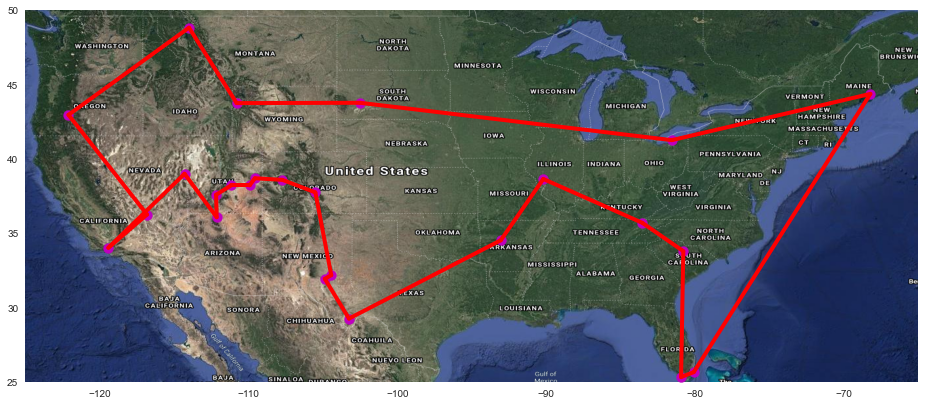

Generation: 99 
Fitness: -158.4954159478606


In [14]:
best_fitness = -99999
best_solution = None
for this_run_name in solutions.keys():
    for this_run_num in range(solutions[this_run_name].shape[0]):
        this_fitness = experiment_results[this_run_name][this_run_num][-1]
        if this_fitness > best_fitness:
            best_fitness = this_fitness
            best_solution = solutions[this_run_name][this_run_num]
            
show_solution_evolution(best_solution.astype(int),final_solution_only=False)

### Q3b: Applying Intuition
One of the nice parts about viewing the solutions coming together over time is that you can see the stepping stones taken to get to good solutions, or where your algorithm may have gotten stuck.  Do the results that you see make sense?  Do you notice anything in particular about the intermediate solutions or search strategy that might inform further algorithmic ideas for the TSP?

**insert text here**

### Q4: Alternative Mutation Opperators
What's a different mutation opperator that you might wanto to implement?  

One that comes to mind for me would be the idea of randomly moving a single entry (gene/park) to another random location in the genome (vs. swapping two).  

What are the potential implication that you could see stemming from this change (or whatever other alternative mutation opperator you want to implement below)?

**insert text here**

### Q4b:  Implementation
Implement this mutation opperator in the cell below

In [15]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=10, num_elements_to_mutate=1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        genome_length: (int) length of the genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,genome_length),dtype=int)
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,genome_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
    
    for generation_num in range(total_generations): # repeat
        
#         print(generation_num)
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
#           # crossover
            if crossover:
                for child, this_parent, other_parent in [[child1, parent1, parent2],[child2, parent2, parent1]]:
                    child.genome = -1*np.ones(len(child.genome))
                    child.genome[0] = this_parent.genome[0]
                    next_index = np.where(other_parent.genome == this_parent.genome[0])
                    while next_index != 0:
                        child.genome[next_index] = this_parent.genome[next_index]
                        next_index = np.where(other_parent.genome == child.genome[next_index])[0]
                    child.genome[np.where(child.genome == -1)] = other_parent.genome[np.where(child.genome == -1)]
                    child.genome = child.genome.astype(int)
                    
#                     print(child.genome)
        
            # mutation
            for this_child in [child1,child2]:
                for _ in range(num_elements_to_mutate):
                    [index_to_swap1, index_to_swap2] = np.random.randint(0,genome_length,2)
                    while index_to_swap1 == index_to_swap2: [index_to_swap1, index_to_swap2] = np.random.randint(0,genome_length,2)
                    orig_gene_1 = this_child.genome[index_to_swap1]
                    this_child.genome = np.delete(this_child.genome,index_to_swap1)
                    this_child.genome = np.insert(this_child.genome,index_to_swap2,orig_gene_1)

            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        population = sorted(population, key=lambda individual: individual.fitness, reverse = True) # sort the full population by each individual's fitness (from highers to lowest)
        
        # tournament selection
        new_population = []
        new_population.append(population[0])
        while len(new_population) < num_parents:
            tournament = np.random.choice(population, size = tournament_size)
            tournament = sorted(tournament, key=lambda individual: individual.fitness, reverse = True)
            new_population.extend(tournament[:num_tournament_winners])    
        population = new_population
        
        # record keeping
        
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num,:] = solution
        
    return fitness_over_time, solutions_over_time # for simplicity, return just the fitness_over_time record

### Q5: Run and Plot Experiment
Yeah, do that.

In [16]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
genome_length = len(park_names)
num_parents = 50
num_children = 50
tournament_size = 10
num_tournament_winners = 2
crossover = False

for run_name in ["random_move_mutation"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions[run_name] = np.zeros((num_runs, total_generations, genome_length))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time = evolutionary_algorithm(fitness_function=traveling_salesman_fitness_function, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions[run_name][run_num] = solutions_over_time
        print(run_name, run_num, time.time()-start_time,fitness_over_time[-1])

random_move_mutation 0 1.1677992343902588 -186.70818491281426
random_move_mutation 1 1.2248456478118896 -164.0115024357517
random_move_mutation 2 1.2100698947906494 -164.64527044637902
random_move_mutation 3 1.156830072402954 -154.42584550741606
random_move_mutation 4 1.1574928760528564 -160.79800299200105
random_move_mutation 5 1.2186477184295654 -170.00909349713393
random_move_mutation 6 1.241408109664917 -157.6870387915288
random_move_mutation 7 1.2419347763061523 -187.53632285569444
random_move_mutation 8 1.1561291217803955 -165.28978157810604
random_move_mutation 9 1.188720464706421 -154.83542581365307
random_move_mutation 10 1.2010128498077393 -181.17342633209432
random_move_mutation 11 1.1718227863311768 -175.09337796277006
random_move_mutation 12 1.2203114032745361 -164.86745706982109
random_move_mutation 13 1.227036714553833 -169.65944940256983
random_move_mutation 14 1.282271146774292 -155.71189524691704
random_move_mutation 15 1.263286828994751 -154.83542581365305
random_mov

plotting swap_entries_mutation
0
10
20
30
40
50
60
70
80
90
plotting random_move_mutation
0
10
20
30
40
50
60
70
80
90


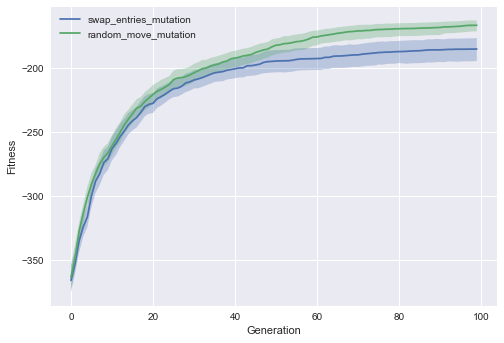

In [17]:
plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results.values(), name = ["swap_entries_mutation","random_move_mutation"], x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)

It may also be helpful (or just fun) to visualize the evolution over time as well.  

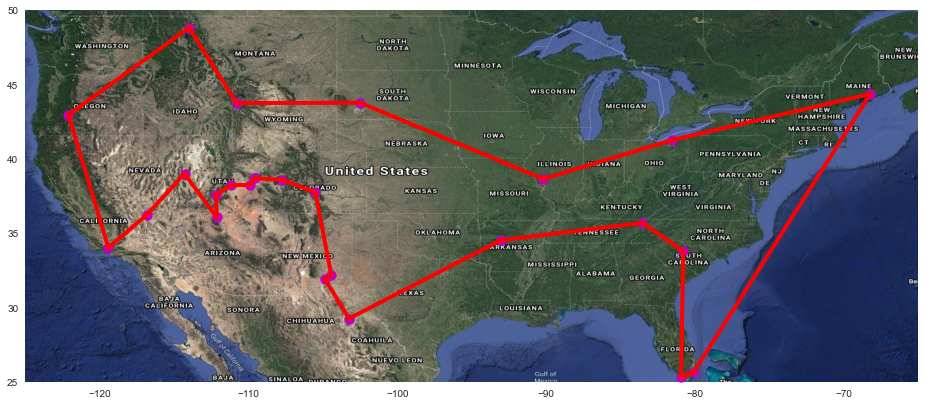

Generation: 99 
Fitness: -154.42584550741606


In [18]:
best_fitness = -99999
best_solution = None
for this_run_name in solutions.keys():
    for this_run_num in range(solutions[this_run_name].shape[0]):
        this_fitness = experiment_results[this_run_name][this_run_num][-1]
        if this_fitness > best_fitness:
            best_fitness = this_fitness
            best_solution = solutions[this_run_name][this_run_num]
            
show_solution_evolution(best_solution.astype(int), final_solution_only=True)

### Q5b: Analysis
Did this approach work better?  Worse?  Indistinguishable from the first?  Was this what you expected?  What does the difference in mutation opperator performance suggest to you about the methods or benefits of crossover?

**insert text here**

### Q6: Crossover

In [19]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=10, num_elements_to_mutate=1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        genome_length: (int) length of the genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,genome_length),dtype=int)
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,genome_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
    
    for generation_num in range(total_generations): # repeat
        
#         print(generation_num)
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
#           # crossover
            if crossover:
                for child, this_parent, other_parent in [[child1, parent1, parent2],[child2, parent2, parent1]]:
                    child.genome = -1*np.ones(len(child.genome))
                    child.genome[0] = this_parent.genome[0]
                    next_index = np.where(other_parent.genome == this_parent.genome[0])
                    while next_index != 0:
                        child.genome[next_index] = this_parent.genome[next_index]
                        next_index = np.where(other_parent.genome == child.genome[next_index])[0]
                    child.genome[np.where(child.genome == -1)] = other_parent.genome[np.where(child.genome == -1)]
                    child.genome = child.genome.astype(int)
        
            # mutation
            for this_child in [child1,child2]:
                for _ in range(num_elements_to_mutate):
                    [index_to_swap1, index_to_swap2] = np.random.randint(0,genome_length,2)
                    while index_to_swap1 == index_to_swap2: [index_to_swap1, index_to_swap2] = np.random.randint(0,genome_length,2)
                    orig_gene_1 = this_child.genome[index_to_swap1]
                    this_child.genome = np.delete(this_child.genome,index_to_swap1)
                    this_child.genome = np.insert(this_child.genome,index_to_swap2,orig_gene_1)

            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        population = sorted(population, key=lambda individual: individual.fitness, reverse = True) # sort the full population by each individual's fitness (from highers to lowest)
        
        # tournament selection
        new_population = []
        new_population.append(population[0])
        while len(new_population) < num_parents:
            tournament = np.random.choice(population, size = tournament_size)
            tournament = sorted(tournament, key=lambda individual: individual.fitness, reverse = True)
            new_population.extend(tournament[:num_tournament_winners])    
        population = new_population
        
        # record keeping
        
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num,:] = solution
        
    return fitness_over_time, solutions_over_time # for simplicity, return just the fitness_over_time record

### Q7: Run and Plot
Just like always.

In [20]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
genome_length = len(park_names)
num_parents = 50
num_children = 50
tournament_size = 10
num_tournament_winners = 2
crossover = True
# experiment_results = {}

for run_name in ["mutation+crossover"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions[run_name] = np.zeros((num_runs, total_generations, genome_length))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time = evolutionary_algorithm(fitness_function=traveling_salesman_fitness_function, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions[run_name][run_num] = solutions_over_time
        print(run_name, run_num, time.time()-start_time,fitness_over_time[-1])

mutation+crossover 0 1.3025453090667725 -208.58580116177674
mutation+crossover 1 1.4475915431976318 -200.0993932687464
mutation+crossover 2 1.4242899417877197 -159.5241181831259
mutation+crossover 3 1.36930513381958 -162.98068600682498
mutation+crossover 4 1.3488154411315918 -160.6089556312756
mutation+crossover 5 1.4872057437896729 -164.0204481662454
mutation+crossover 6 1.3268368244171143 -160.7527682246875
mutation+crossover 7 1.378932237625122 -161.84654765593703
mutation+crossover 8 1.3796706199645996 -199.03082585415748
mutation+crossover 9 1.3466219902038574 -188.22003460936375
mutation+crossover 10 1.32871413230896 -154.42584550741606
mutation+crossover 11 1.3539073467254639 -194.04107715441026
mutation+crossover 12 1.4002227783203125 -187.6775299694033
mutation+crossover 13 1.343109130859375 -175.47546061007216
mutation+crossover 14 1.4607017040252686 -172.39409897524783
mutation+crossover 15 1.4016444683074951 -156.41722702453444
mutation+crossover 16 1.4993922710418701 -169.

plotting swap_entries_mutation
0
10
20
30
40
50
60
70
80
90
plotting random_move_mutation
0
10
20
30
40
50
60
70
80
90
plotting mutation+crossover
0
10
20
30
40
50
60
70
80
90


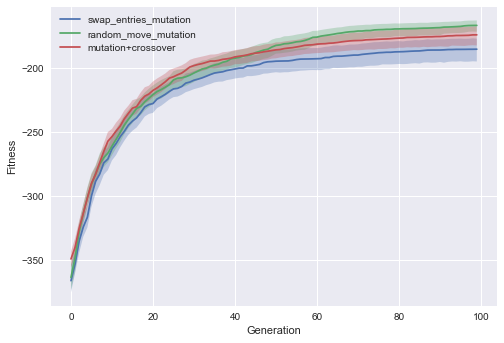

In [21]:
plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results.values(), name = ["swap_entries_mutation","random_move_mutation","mutation+crossover"], x_label = "Generation", y_label = "Fitness")

### Q7b: Analysis
Did crossover help?  Any thoughts as to why or why not?  Is this what you expected?

**insert text here**

### Q8: Scaling Up
Now that you've tested some approaches on a subset of the data, let's try the best method on the full park list.  First let's re-import the complete parks list. 

In [22]:
file = open("parks_list.csv", encoding='utf-8')
park_names = []
park_lat_long = []
for line in file:
    park_name = line.split(",")[0].strip()
    park_lat = float(line.split(",")[1].strip())
    park_long = float(line.split(",")[2].strip())
    
    if park_lat > -125 and park_lat < -65 and park_long > 25 and park_lat < 50: # just look at continental US
        park_names.append(park_name)
        park_lat_long.append([park_lat,park_long])
        
file.close()
park_lat_long = np.array(park_lat_long)

print("Number of National Parks in Continental US:",len(park_names))
print(park_names)

Number of National Parks in Continental US: 50
['Acadia', 'Arches', 'Badlands', 'Big Bend', 'Biscayne', 'Black Canyon of the Gunnison', 'Bryce Canyon', 'Canyonlands', 'Capitol Reef', 'Carlsbad Caverns', 'Channel Islands', 'Congaree', 'Crater Lake', 'Cuyahoga Valley', 'Death Valley', 'Everglades', 'Gateway Arch', 'Glacier', 'Grand Canyon', 'Grand Teton', 'Great Basin', 'Great Sand Dunes', 'Great Smoky Mountains', 'Guadalupe Mountains', 'Hot Springs', 'Indiana Dunes', 'Isle Royale', 'Joshua Tree', 'Kings Canyon', 'Lassen Volcanic', 'Mammoth Cave', 'Mesa Verde', 'Mount Rainier', 'New River Gorge', 'North Cascades', 'Olympic', 'Petrified Forest', 'Pinnacles', 'Redwood', 'Rocky Mountain', 'Saguaro', 'Sequoia', 'Shenandoah', 'Theodore Roosevelt', 'Voyageurs', 'White Sands', 'Wind Cave', 'Yellowstone', 'Yosemite', 'Zion']


This larger dataset will need to run for a bit longer, let's say `1000` generations.  We can keep all other parameters the same, though let's drop the number of independent trials down to `10`, again to keep computation reasonable.  Each run takes a little under 20 seconds on my laptop, so this should still only take a few minutes to run.  

Feel free to just run your best approach (e.g. combination of mutation and/or crossover opperators) from the smaller dataset here.  

In [26]:
num_runs = 10
total_generations = 1000
num_elements_to_mutate = 1
genome_length = len(park_names)
num_parents = 50
num_children = 50
tournament_size = 10
num_tournament_winners = 2
crossover = False
# experiment_results = {}

for run_name in ["random_move_mutation"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions[run_name] = np.zeros((num_runs, total_generations, genome_length))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time = evolutionary_algorithm(fitness_function=traveling_salesman_fitness_function, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions[run_name][run_num] = solutions_over_time
        print(run_name, run_num, time.time()-start_time,fitness_over_time[-1])

random_move_mutation 0 15.304347038269043 -252.4991010199205
random_move_mutation 1 15.221306324005127 -229.49306049601446
random_move_mutation 2 15.66269326210022 -207.29911871389046
random_move_mutation 3 14.58707571029663 -239.3103440652941
random_move_mutation 4 14.506364583969116 -205.6645866043239
random_move_mutation 5 14.56163215637207 -218.5095523487307
random_move_mutation 6 14.438761472702026 -252.7755135903387
random_move_mutation 7 14.657381057739258 -246.1831462867839
random_move_mutation 8 14.571889162063599 -242.40329490188387
random_move_mutation 9 14.538126945495605 -249.10400531641227


Please also plot the fitness over time.  Though feel free to omit the boostrapped confidence intervals, as they take quite some time to run over 1000 generations.  

plotting mutation+crossover


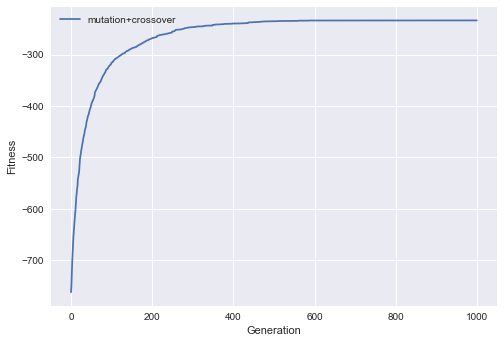

In [27]:
plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results.values(), name = ["mutation+crossover"], x_label = "Generation", y_label = "Fitness", plot_bootstrap = False)

Let's also visualize the optimization over time!

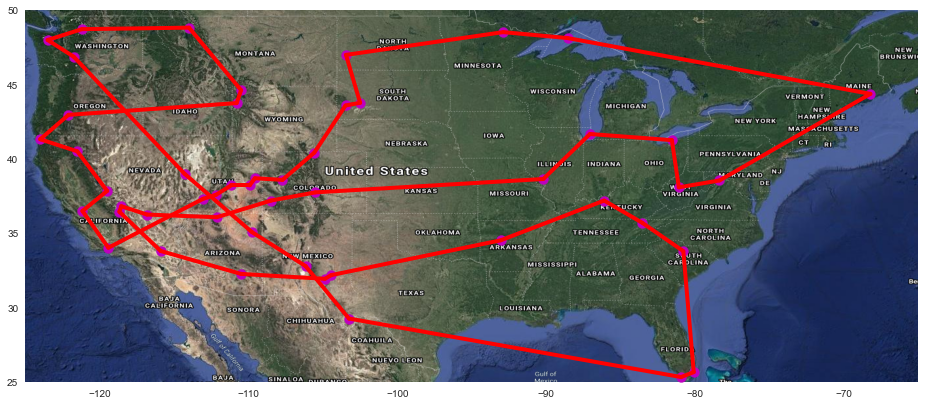

Generation: 999 
Fitness: -257.68803977882476


In [28]:
best_fitness = 9999
best_solution = None
for this_run_name in solutions.keys():
    for this_run_num in range(solutions[this_run_name].shape[0]):
        this_fitness = experiment_results[this_run_name][this_run_num][-1]
        if this_fitness < best_fitness:
            best_fitness = this_fitness
            best_solution = solutions[this_run_name][this_run_num]
            
show_solution_evolution(best_solution.astype(int), final_solution_only = False)

### Q9: Analysis at Scale
Do you notice anything different viewing these results at scale?  Does it work as well?  What relationships or patterns do you see between the smaller and larger TSP problems that might help to inform how well of a proxy one is for the other?

**insert text here**

### Q10: Future Work
If any of these results were less than perfect solutions (including this last one at scale), what might still be standing in the way?  You might think about our discussions on search landscapes, local optima, and selection pressure, or consider additonal modificaitons to the variation pperators, selction criteria, or viability constraints, among many other ideas of potential future directions.  

**insert text here**

### Congratulations, you made it to the end!
Nice work -- and hopefully you're starting to get the hang of these!

Please save this file as a .ipynb, and also download it as a .pdf, uploading **both** to blackboard to complete this assignment.  

For your submission, please make sure that you have renamed this file (and that the resulting pdf follows suit) to replce `[netid]` with your UVM netid.  This will greatly simplify our grading pipeline, and make sure that you receive credit for your work.  

#### Academic Integrity Attribution
During this assignment I collaborated with:

**insert text here**